In [58]:
import numpy as np
import matplotlib.pylab as plt
import padasip as pa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from pyedflib import highlevel

# interactive plots
%matplotlib widget 

In [59]:
filename = r"PASA-Projects\n6.edf copy" 
# Read the EDF file
signals, signal_headers, header = highlevel.read_edf(filename)

print("Number of channels:", len(signals))
print("Names of channels:", [sh['label'] for sh in signal_headers])
print("Signal shape:", signals[0].shape)
print("Headers:", header)
# print("Sampling frequency:", signal_headers[0]['sample_rate'])
print(signal_headers[0].keys())
fs = signal_headers[0]['sample_frequency']
print("Sampling frequency:", fs)


Number of channels: 8
Names of channels: ['LOC-A1', 'ROC-A2', 'EMG-EMG', 'C3-A2', 'O2-A1', 'ECG', 'TAG', 'THE']
Signal shape: (4048000,)
Headers: {'technician': '', 'recording_additional': '', 'patientname': '', 'patient_additional': '', 'patientcode': '', 'equipment': '', 'admincode': '', 'sex': '', 'startdate': datetime.datetime(1999, 1, 1, 22, 33, 9), 'birthdate': '', 'gender': '', 'annotations': []}
dict_keys(['label', 'dimension', 'sample_frequency', 'physical_max', 'physical_min', 'digital_max', 'digital_min', 'prefilter', 'transducer'])
Sampling frequency: 128.0


In [60]:
start = int(10700*fs) # Samples
end = int(start + 30*fs) # Samples
for i, sig in enumerate(signals):
    if signal_headers[i]['label'] == 'LOC-A1':
        eog_left = sig[start:end]
    elif signal_headers[i]['label'] == 'ROC-A2':
        eog_right = sig[start:end]
    elif signal_headers[i]['label'] == 'EMG-EMG':
        emg = sig[start:end]
    elif signal_headers[i]['label'] == 'C3-A2':
        eeg = sig[start:end]


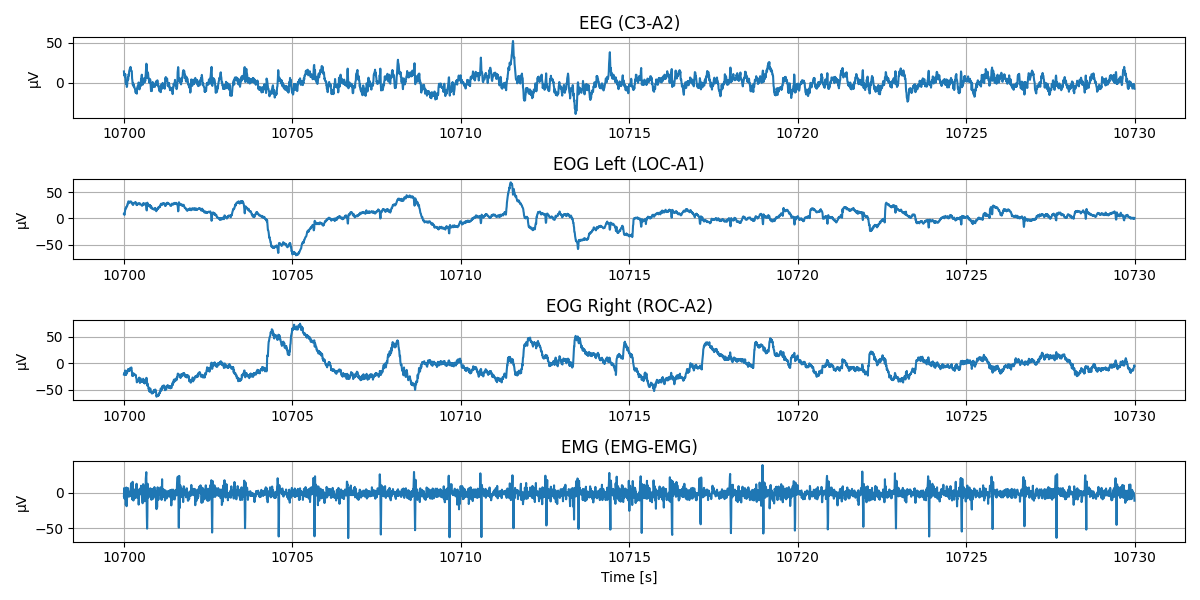

In [61]:
# plot the raw signals over time
t = np.arange(start, end) / fs  # time in seconds

plt.figure(figsize=(12,6))

plt.subplot(4,1,1)
plt.plot(t, eeg)
plt.title("EEG (C3-A2)")
plt.ylabel("µV")
plt.grid(True)

plt.subplot(4,1,2)
plt.plot(t, eog_left)
plt.title("EOG Left (LOC-A1)")
plt.ylabel("µV")
plt.grid(True)

plt.subplot(4,1,3)
plt.plot(t, eog_right)
plt.title("EOG Right (ROC-A2)")
plt.ylabel("µV")
plt.grid(True)

plt.subplot(4,1,4)
plt.plot(t, emg)
plt.title("EMG (EMG-EMG)")
plt.xlabel("Time [s]")
plt.ylabel("µV")
plt.grid(True)

plt.tight_layout()
plt.show()



The waveforms (contained in the .edf files of the database) include at least 3 EEG channels (F3 or F4, C3 or C4 and O1 or O2, referred to A1 or A2), EOG (2 channels), EMG of the submentalis muscle, bilateral anterior tibial EMG, respiration signals (airflow, abdominal and thoracic effort and SaO2) and EKG.

In [62]:
def data_tap(x, M):
  '''
  Genera la matriz de taps MxN
  '''
  N = x.size
  x = np.array(x).reshape(N)
  x_M = np.zeros((N,M))
  
  # Zero-padding
  for m in range(M):
    x_M[m:,m] = x[:N-m]

  return x_M

In [63]:
M = 200 # Filterlength M
mu = 0.000003 # Learning rate/step size
# t = np.arange(N)

### Example signals ###
eog_ref = eog_left
emg_ref = emg
eeg = eeg

### 1. EOG Filtering with LMS ###
x_1 = eog_ref 
x_1_tap = data_tap(x_1, M)
d_1 = eeg
# Create LMS-filter
f1 = pa.filters.FilterLMS(n = M, mu = mu, w='zeros') 
y1, e1, w1 = f1.run(d_1,x_1_tap)

### 2. EMG Filtering ###
x2 = emg_ref                # Reference Data: EMG
x2_M = data_tap(x2, M)
# Create NLMS-filter (NLMS is used at the end because it adapts more robustly to varying noise levels (typical in ECG signals))
f2 = pa.filters.FilterLMS(n = M, mu = mu, w='zeros')
y2, e2, w2 = f2.run(e1,x2_M)

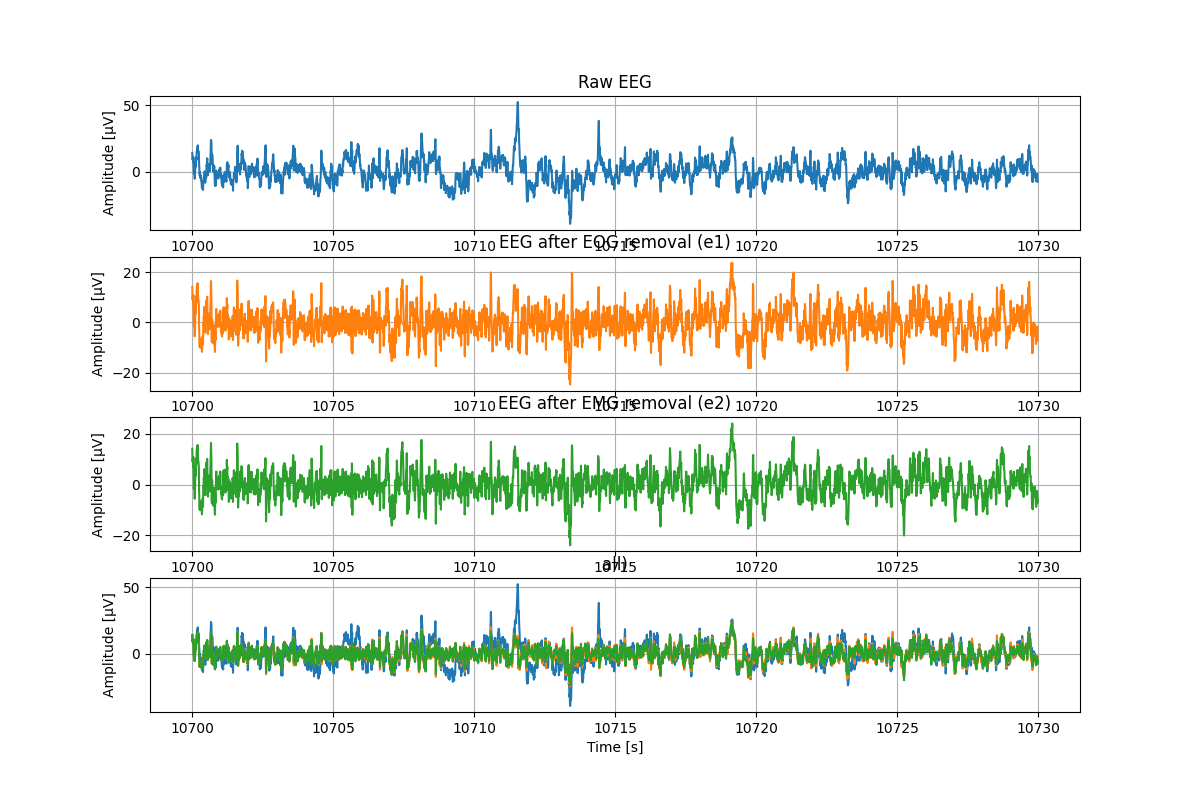

In [64]:
# Plot
plt.figure(figsize=(12,8))

plt.subplot(4,1,1)
plt.plot(t, eeg, color='tab:blue')
plt.title("Raw EEG")
plt.ylabel("Amplitude [µV]")
plt.grid(True)

plt.subplot(4,1,2)
plt.plot(t, e1, color='tab:orange')
plt.title("EEG after EOG removal (e1)")
plt.ylabel("Amplitude [µV]")
plt.grid(True)

plt.subplot(4,1,3)
plt.plot(t, e2, color='tab:green')
plt.title("EEG after EMG removal (e2)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [µV]")
plt.grid(True)

plt.subplot(4,1,4)
plt.plot(t, eeg, color='tab:blue')
plt.plot(t, e1, color='tab:orange')
plt.plot(t, e2, color='tab:green')
plt.title("all)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [µV]")
plt.grid(True)

plt.show()

In [65]:
# Compute PSDs
nperseg = 1024
f_eeg, Pxx_eeg = welch(eeg, fs=fs, nperseg=nperseg)
f_e1, Pxx_e1 = welch(e1, fs=fs, nperseg=nperseg)
f_e2, Pxx_e2 = welch(e2, fs=fs, nperseg=nperseg)

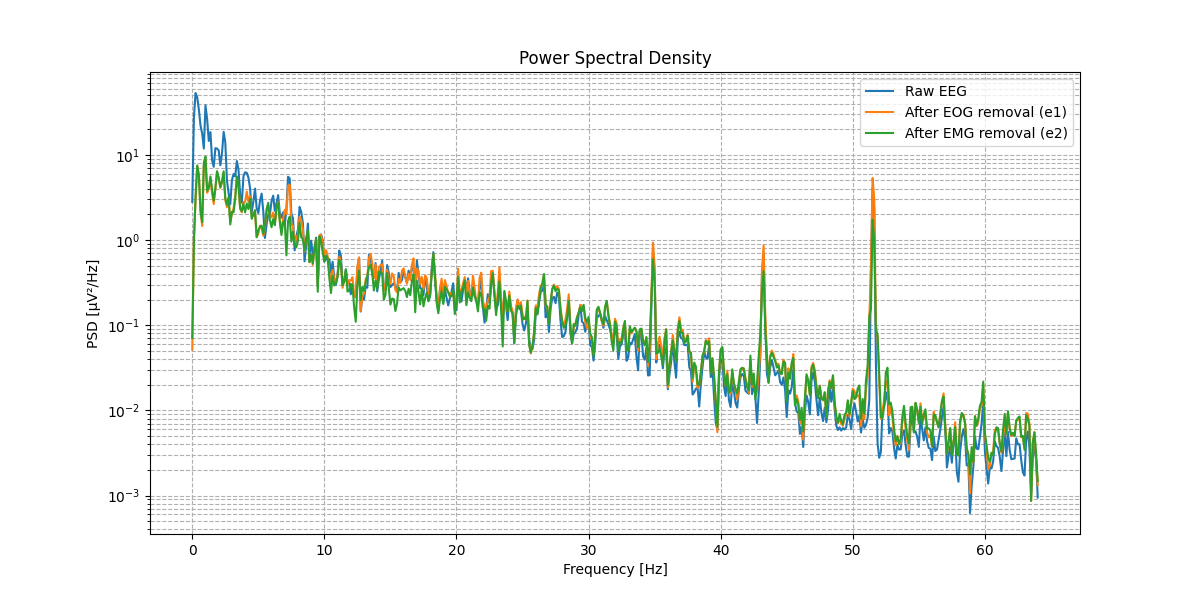

In [66]:
# Plot PSDs
plt.figure(figsize=(12,6))
plt.semilogy(f_eeg, Pxx_eeg, label='Raw EEG')
plt.semilogy(f_e1, Pxx_e1, label='After EOG removal (e1)')
plt.semilogy(f_e2, Pxx_e2, label='After EMG removal (e2)')

plt.title('Power Spectral Density')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [µV²/Hz]')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()


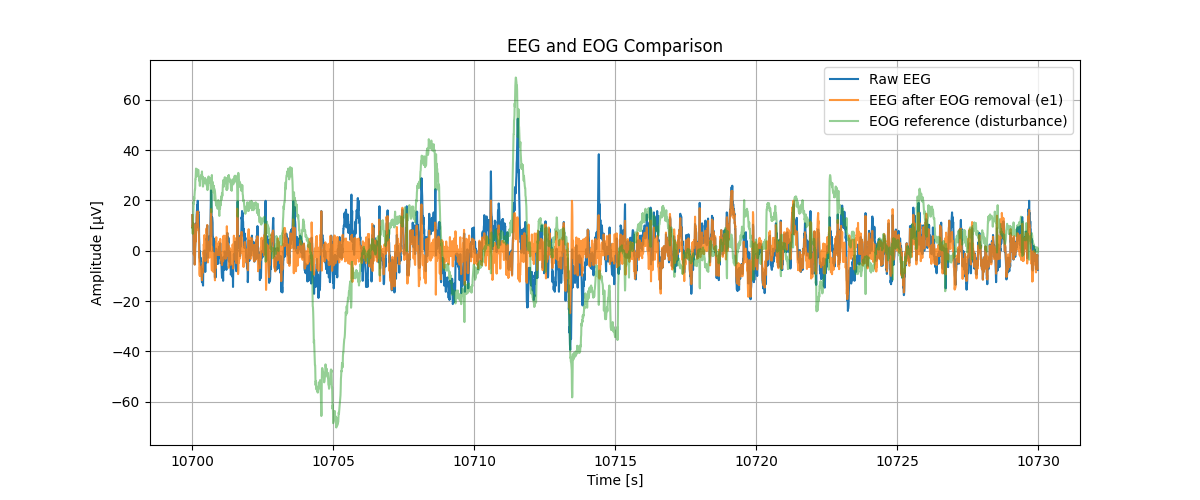

In [67]:
plt.figure(figsize=(12,5))
plt.plot(t, eeg, label='Raw EEG', color='tab:blue')
plt.plot(t, e1, label='EEG after EOG removal (e1)', color='tab:orange', alpha=0.8)
plt.plot(t, eog_left, label='EOG reference (disturbance)', color='tab:green', alpha=0.5)

plt.title('EEG and EOG Comparison')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [µV]')
plt.legend()
plt.grid(True)
plt.show()